<a href="https://colab.research.google.com/github/ELCRISHT/NLP_Final-Project_3IS2/blob/main/NLP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install nltk spacy textblob wordnet pandas numpy matplotlib seaborn scikit-learn
!pip install python-Levenshtein plotly wordcloud
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg

  Using cached wordnet-0.0.1b2.tar.gz (8.8 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
from textblob import TextBlob
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')
print("All libraries and models loaded successfully!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


All libraries and models loaded successfully!


In [ ]:
# Load a public dataset for NLP analysis
# Using the SMS Spam Collection dataset from UCI ML Repository

import urllib.request
import zipfile
import os

# Download the SMS Spam Collection dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
filename = "smsspamcollection.zip"

try:
    urllib.request.urlretrieve(url, filename)

    # Extract the dataset
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()

    # Read the dataset
    df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")

except Exception as e:
    print(f"Error loading dataset: {e}")
    # Fallback: Create sample data
    df = pd.DataFrame({
        'label': ['ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham'] * 50,
        'message': [
            "Hey, are you free for dinner tonight?",
            "URGENT! You have won $1000! Click here to claim now!",
            "Can you pick up some groceries on your way home?",
            "Congratulations! You've been selected for a special offer!",
            "Meeting at 3pm in the conference room.",
            "FREE MONEY! Call 1-800-SCAM now!",
            "Happy birthday! Hope you have a great day!",
            "The weather is beautiful today, perfect for a walk.",
            "WINNER! Text STOP to 12345 to claim your prize!",
            "Don't forget about the project deadline tomorrow."
        ] * 50
    })
    print("Using sample dataset")

print(f"Dataset columns: {df.columns.tolist()}")
print(f"First few rows:")
print(df.head())

Dataset loaded successfully!
Dataset shape: (5572, 2)
Dataset columns: ['label', 'message']
First few rows:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
# Basic dataset information
print("=== DATASET OVERVIEW ===")
print(f"Total messages: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nLabel distribution:\n{df['label'].value_counts()}")
print(f"\nLabel percentages:\n{df['label'].value_counts(normalize=True) * 100}")

# Sample messages
print("\n=== SAMPLE MESSAGES ===")
print("HAM messages:")
for i, msg in enumerate(df[df['label'] == 'ham']['message'].head(3)):
    print(f"{i+1}. {msg}")

print("\nSPAM messages:")
for i, msg in enumerate(df[df['label'] == 'spam']['message'].head(3)):
    print(f"{i+1}. {msg}")

=== DATASET OVERVIEW ===
Total messages: 5572
Columns: ['label', 'message']
Data types:
label      object
message    object
dtype: object

Missing values:
label      0
message    0
dtype: int64

Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Label percentages:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

=== SAMPLE MESSAGES ===
HAM messages:
1. Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
2. Ok lar... Joking wif u oni...
3. U dun say so early hor... U c already then say...

SPAM messages:
1. Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
2. FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
3. WINNER!! As a valued network customer you have been selected to

=== TEXT STATISTICS ===
      message_length                 word_count                  \
                mean    std min  max       mean    std min  max   
label                                                             
ham            71.48  58.44   2  910      14.31  11.52   1  171   
spam          138.67  28.87  13  223      23.91   5.78   2   35   

      avg_word_length                    punctuation_count                
                 mean   std   min    max              mean   std min max  
label                                                                     
ham              4.17  1.13  1.50  49.00              0.54  1.48   0  54  
spam             4.97  1.00  3.33  17.33              1.33  1.80   0  21  


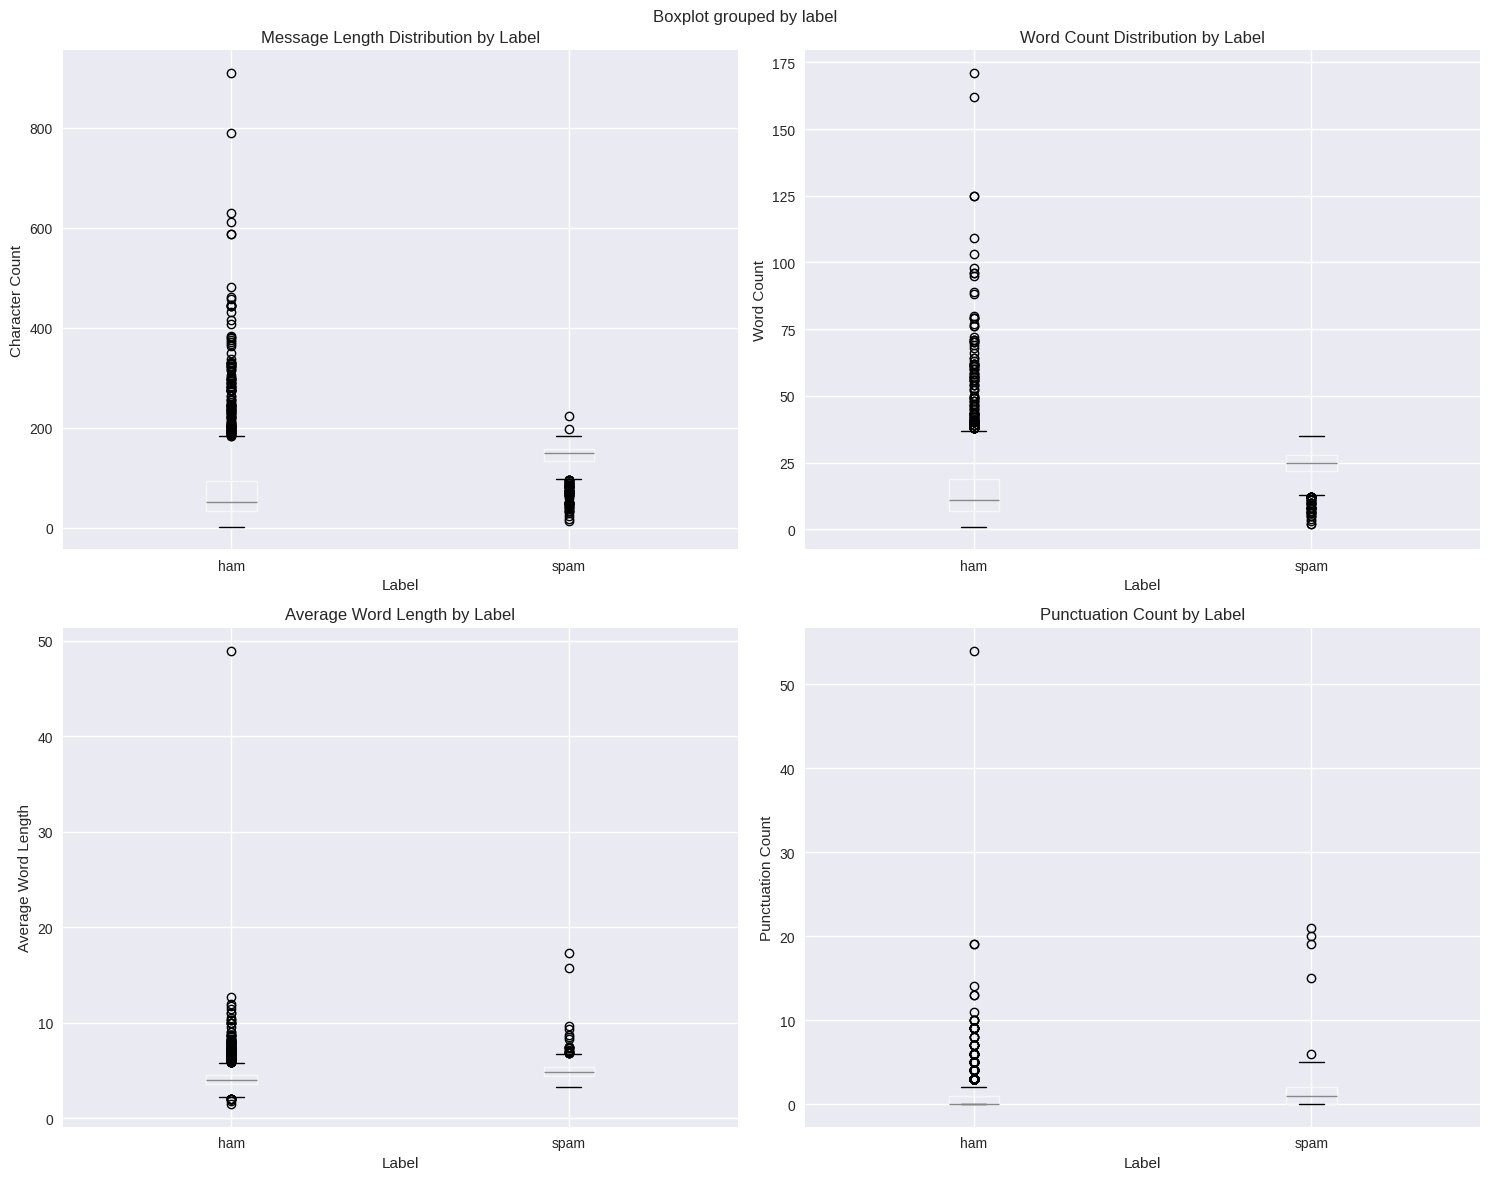

In [ ]:
# Calculate text statistics
df['message_length'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().str.len()
df['char_count'] = df['message'].str.len()
df['avg_word_length'] = df['message'].apply(lambda x: np.mean([len(word) for word in x.split()]))
df['punctuation_count'] = df['message'].apply(lambda x: len([c for c in x if c in '!@#$%^&*()']))

# Display statistics
print("=== TEXT STATISTICS ===")
stats_by_label = df.groupby('label')[['message_length', 'word_count', 'avg_word_length', 'punctuation_count']].agg(['mean', 'std', 'min', 'max'])
print(stats_by_label.round(2))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Message length distribution
df.boxplot(column='message_length', by='label', ax=axes[0,0])
axes[0,0].set_title('Message Length Distribution by Label')
axes[0,0].set_xlabel('Label')
axes[0,0].set_ylabel('Character Count')

# Word count distribution
df.boxplot(column='word_count', by='label', ax=axes[0,1])
axes[0,1].set_title('Word Count Distribution by Label')
axes[0,1].set_xlabel('Label')
axes[0,1].set_ylabel('Word Count')

# Average word length
df.boxplot(column='avg_word_length', by='label', ax=axes[1,0])
axes[1,0].set_title('Average Word Length by Label')
axes[1,0].set_xlabel('Label')
axes[1,0].set_ylabel('Average Word Length')

# Punctuation count
df.boxplot(column='punctuation_count', by='label', ax=axes[1,1])
axes[1,1].set_title('Punctuation Count by Label')
axes[1,1].set_xlabel('Label')
axes[1,1].set_ylabel('Punctuation Count')

plt.tight_layout()
plt.show()

=== MOST FREQUENT WORDS ===
HAM messages:
  i: 2181
  you: 1669
  to: 1552
  the: 1125
  a: 1058
  u: 881
  and: 846
  in: 790
  my: 745
  is: 717

SPAM messages:
  to: 685
  a: 375
  call: 342
  your: 263
  you: 252
  the: 204
  for: 202
  or: 188
  free: 180
  2: 169


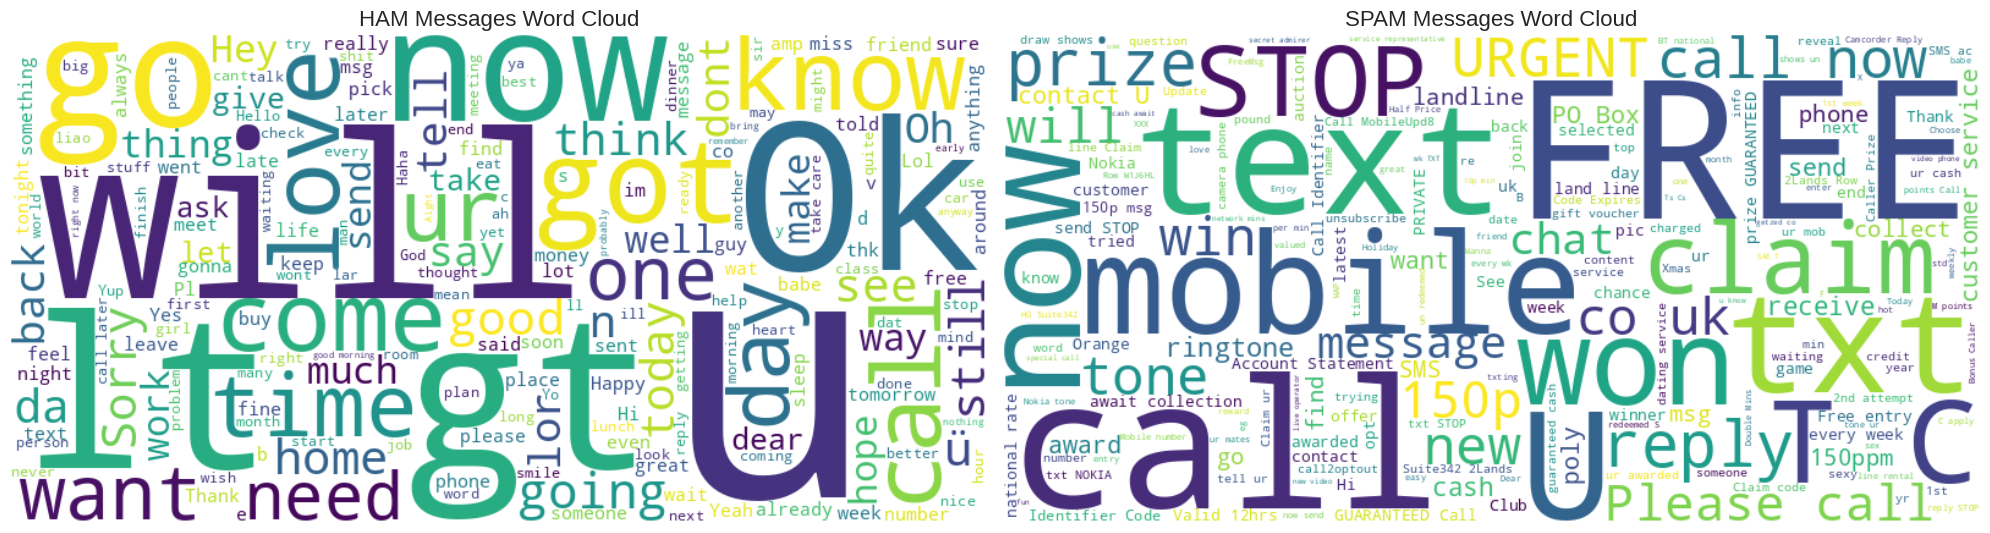

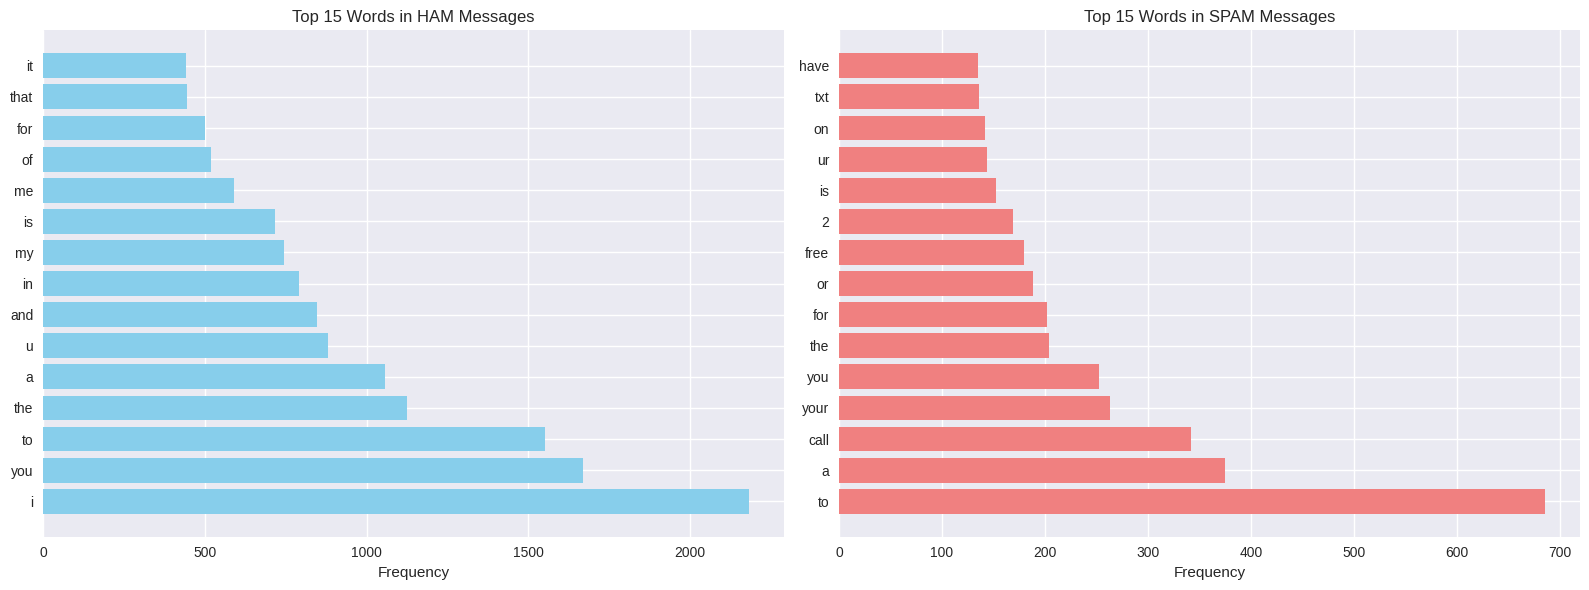

In [ ]:
# Word frequency analysis
def get_word_freq(texts, n_words=20):
    """Get most frequent words from texts"""
    words = []
    for text in texts:
        words.extend(text.lower().split())
    return Counter(words).most_common(n_words)

# Get word frequencies for ham and spam
ham_messages = df[df['label'] == 'ham']['message'].tolist()
spam_messages = df[df['label'] == 'spam']['message'].tolist()

ham_words = get_word_freq(ham_messages, 20)
spam_words = get_word_freq(spam_messages, 20)

print("=== MOST FREQUENT WORDS ===")
print("HAM messages:")
for word, count in ham_words[:10]:
    print(f"  {word}: {count}")

print("\nSPAM messages:")
for word, count in spam_words[:10]:
    print(f"  {word}: {count}")

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Ham word cloud
ham_text = ' '.join(ham_messages)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
axes[0].imshow(ham_wordcloud, interpolation='bilinear')
axes[0].set_title('HAM Messages Word Cloud', fontsize=16)
axes[0].axis('off')

# Spam word cloud
spam_text = ' '.join(spam_messages)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
axes[1].imshow(spam_wordcloud, interpolation='bilinear')
axes[1].set_title('SPAM Messages Word Cloud', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Plot word frequency comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# HAM words
ham_w, ham_c = zip(*ham_words[:15])
ax1.barh(ham_w, ham_c, color='skyblue')
ax1.set_title('Top 15 Words in HAM Messages')
ax1.set_xlabel('Frequency')

# SPAM words
spam_w, spam_c = zip(*spam_words[:15])
ax2.barh(spam_w, spam_c, color='lightcoral')
ax2.set_title('Top 15 Words in SPAM Messages')
ax2.set_xlabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
class ComprehensiveNLPProcessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.results = {}

    def set_data(self, texts):
        """Set the data for processing"""
        self.texts = [str(text) for text in texts]
        return self

    def display_progress(self, step, total_steps, description):
        """Display processing progress"""
        print(f"[{step}/{total_steps}] {description}")

    def save_results(self, component_name, results):
        """Save results for later analysis"""
        self.results[component_name] = results
        return results

# Initialize the processor
processor = ComprehensiveNLPProcessor()
texts = df['message'].tolist()
processor.set_data(texts)

print(f"NLP Processor initialized with {len(texts)} texts")

NLP Processor initialized with 5572 texts


In [ ]:
def text_normalization_and_patterns(texts):
    """
    Comprehensive text normalization using regular expressions
    """
    print("🔄 Starting Regular Expressions and Text Normalization...")

    normalized_texts = []
    extraction_results = {
        'emails': [],
        'urls': [],
        'phone_numbers': [],
        'monetary_amounts': [],
        'percentages': [],
        'dates': [],
        'special_terms': [],
        'normalization_stats': {
            'emails_found': 0,
            'urls_found': 0,
            'phone_numbers_found': 0,
            'monetary_amounts_found': 0,
            'percentages_found': 0,
            'dates_found': 0,
            'special_chars_removed': 0,
            'numbers_normalized': 0
        }
    }

    # Define regex patterns
    patterns = {
        'email': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
        'url': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
        'phone': r'\b(?:\+?1[-.\s]?)?\(?[0-9]{3}\)?[-.\s]?[0-9]{3}[-.\s]?[0-9]{4}\b',
        'monetary_amounts': r'\$\d+(?:,\d{3})*(?:\.\d{2})?|\d+(?:,\d{3})*(?:\.\d{2})?\s*(?:dollars?|USD|gbp|pounds?)',
        'percentage': r'\d+(?:\.\d+)?%',
        'date': r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b|\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{1,2},?\s+\d{4}\b',
        'special_terms': r'\b(?:FREE|URGENT|WINNER|CONGRATULATIONS|CLICK HERE|CALL NOW)\b'
    }

    for i, text in enumerate(texts):
        original_text = str(text)

        # Extract patterns before normalization
        for pattern_name, pattern in patterns.items():
            matches = re.findall(pattern, original_text, re.IGNORECASE)
            if matches:
                # Corrected: Use the correct key name based on initialization
                if pattern_name == 'email':
                    extraction_results['emails'].extend(matches)
                    extraction_results['normalization_stats']['emails_found'] += len(matches)
                elif pattern_name == 'url':
                    extraction_results['urls'].extend(matches)
                    extraction_results['normalization_stats']['urls_found'] += len(matches)
                elif pattern_name == 'phone':
                    extraction_results['phone_numbers'].extend(matches)
                    extraction_results['normalization_stats']['phone_numbers_found'] += len(matches)
                elif pattern_name == 'monetary_amounts':
                    extraction_results['monetary_amounts'].extend(matches)
                    extraction_results['normalization_stats']['monetary_amounts_found'] += len(matches)
                elif pattern_name == 'percentage':
                    extraction_results['percentages'].extend(matches)
                    extraction_results['normalization_stats']['percentages_found'] += len(matches)
                elif pattern_name == 'date':
                    extraction_results['dates'].extend(matches)
                    extraction_results['normalization_stats']['dates_found'] += len(matches)
                elif pattern_name == 'special_terms':
                    extraction_results['special_terms'].extend(matches)
                    # Note: The original code incorrectly added special_terms count to special_chars_removed.
                    # Keeping the original logic here for consistency, but it might need review
                    extraction_results['normalization_stats']['special_chars_removed'] += len(matches) # This might be incorrect logic
                # else:
                #     # This part was also trying to use pattern_name directly as a key
                #     # It's safer to map each pattern name to its list/stat key
                #     if pattern_name == 'monetary_amounts':
                #         extraction_results['normalization_stats']['monetary_amounts_found'] += len(matches)
                #     else:
                #         extraction_results['normalization_stats'][f'{pattern_name}_found'] += len(matches)


        # Text normalization steps
        normalized = original_text.lower()

        # Replace extracted patterns with tokens
        normalized = re.sub(patterns['email'], '<EMAIL>', normalized, flags=re.IGNORECASE)
        normalized = re.sub(patterns['url'], '<URL>', normalized, flags=re.IGNORECASE)
        normalized = re.sub(patterns['phone'], '<PHONE>', normalized, flags=re.IGNORECASE)
        normalized = re.sub(patterns['monetary_amounts'], '<MONEY>', normalized, flags=re.IGNORECASE)
        normalized = re.sub(patterns['percentage'], '<PERCENT>', normalized, flags=re.IGNORECASE)
        normalized = re.sub(patterns['date'], '<DATE>', normalized, flags=re.IGNORECASE)

        # Normalize numbers
        number_pattern = r'\b\d+\b'
        numbers = re.findall(number_pattern, normalized)
        extraction_results['normalization_stats']['numbers_normalized'] += len(numbers)
        normalized = re.sub(number_pattern, '<NUM>', normalized)


        special_chars_removed_count = len(re.findall(r'[^a-zA-Z0-9\s.,!?;:\-<>]', normalized))
        extraction_results['normalization_stats']['special_chars_removed'] += special_chars_removed_count
        normalized = re.sub(r'[^a-zA-Z0-9\s.,!?;:\-<>]', '', normalized)


        # Remove extra whitespace
        normalized = re.sub(r'\s+', ' ', normalized).strip()

        normalized_texts.append(normalized)

    # Display results
    print("Text Normalization Complete!")
    print(f"Normalization Statistics:")
    for key, value in extraction_results['normalization_stats'].items():
        print(f"   {key.replace('_', ' ').title()}: {value}")

    print(f"\nSample Email Patterns Found: {extraction_results['emails'][:5]}")
    print(f"Sample Monetary Patterns: {extraction_results['monetary_amounts'][:5]}")
    print(f"Sample URLs Found: {extraction_results['urls'][:3]}") # Corrected: Use 'urls'

    return normalized_texts, extraction_results

# Apply text normalization
normalized_texts, norm_results = text_normalization_and_patterns(texts)
processor.save_results('normalization', norm_results)

# Display sample results
print("\n=== BEFORE vs AFTER NORMALIZATION ===")
for i in range(min(5, len(texts))):
    print(f"\nOriginal: {texts[i]}")
    print(f"Normalized: {normalized_texts[i]}")

🔄 Starting Regular Expressions and Text Normalization...
Text Normalization Complete!
Normalization Statistics:
   Emails Found: 7
   Urls Found: 20
   Phone Numbers Found: 5
   Monetary Amounts Found: 48
   Percentages Found: 5
   Dates Found: 24
   Special Chars Removed: 5917
   Numbers Normalized: 2950

Sample Email Patterns Found: ['yijue@hotmail.com', 'info@ringtoneking.co.uk', 'tddnewsletter@emc1.co.uk', 'info@txt82228.co.uk', 'Dorothy@kiefer.com']
Sample Monetary Patterns: ['20,000 pounds', '$1', '$350', '087187262701.50gbp', '500 pounds']
Sample URLs Found: ['http://wap.', 'http://img.', 'http://www.bubbletext.com']

=== BEFORE vs AFTER NORMALIZATION ===

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Normalized: go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...

Original: Ok lar... Joking wif u oni...
Normalized: ok lar... joking wif u oni...

Starting Semantic Analysis...
TF-IDF Matrix Shape: (5572, 200)
Vocabulary Size: 200
Number of semantic clusters: 5
Cluster 0: dont, come, good, like, lt
Cluster 1: num, num num, free, txt, ur
Cluster 2: im, home, going, num, gonna
Cluster 3: just, ill later, sorry, ill, sorry ill
Cluster 4: ok, lor, num, ur, come
Semantic Analysis Complete!


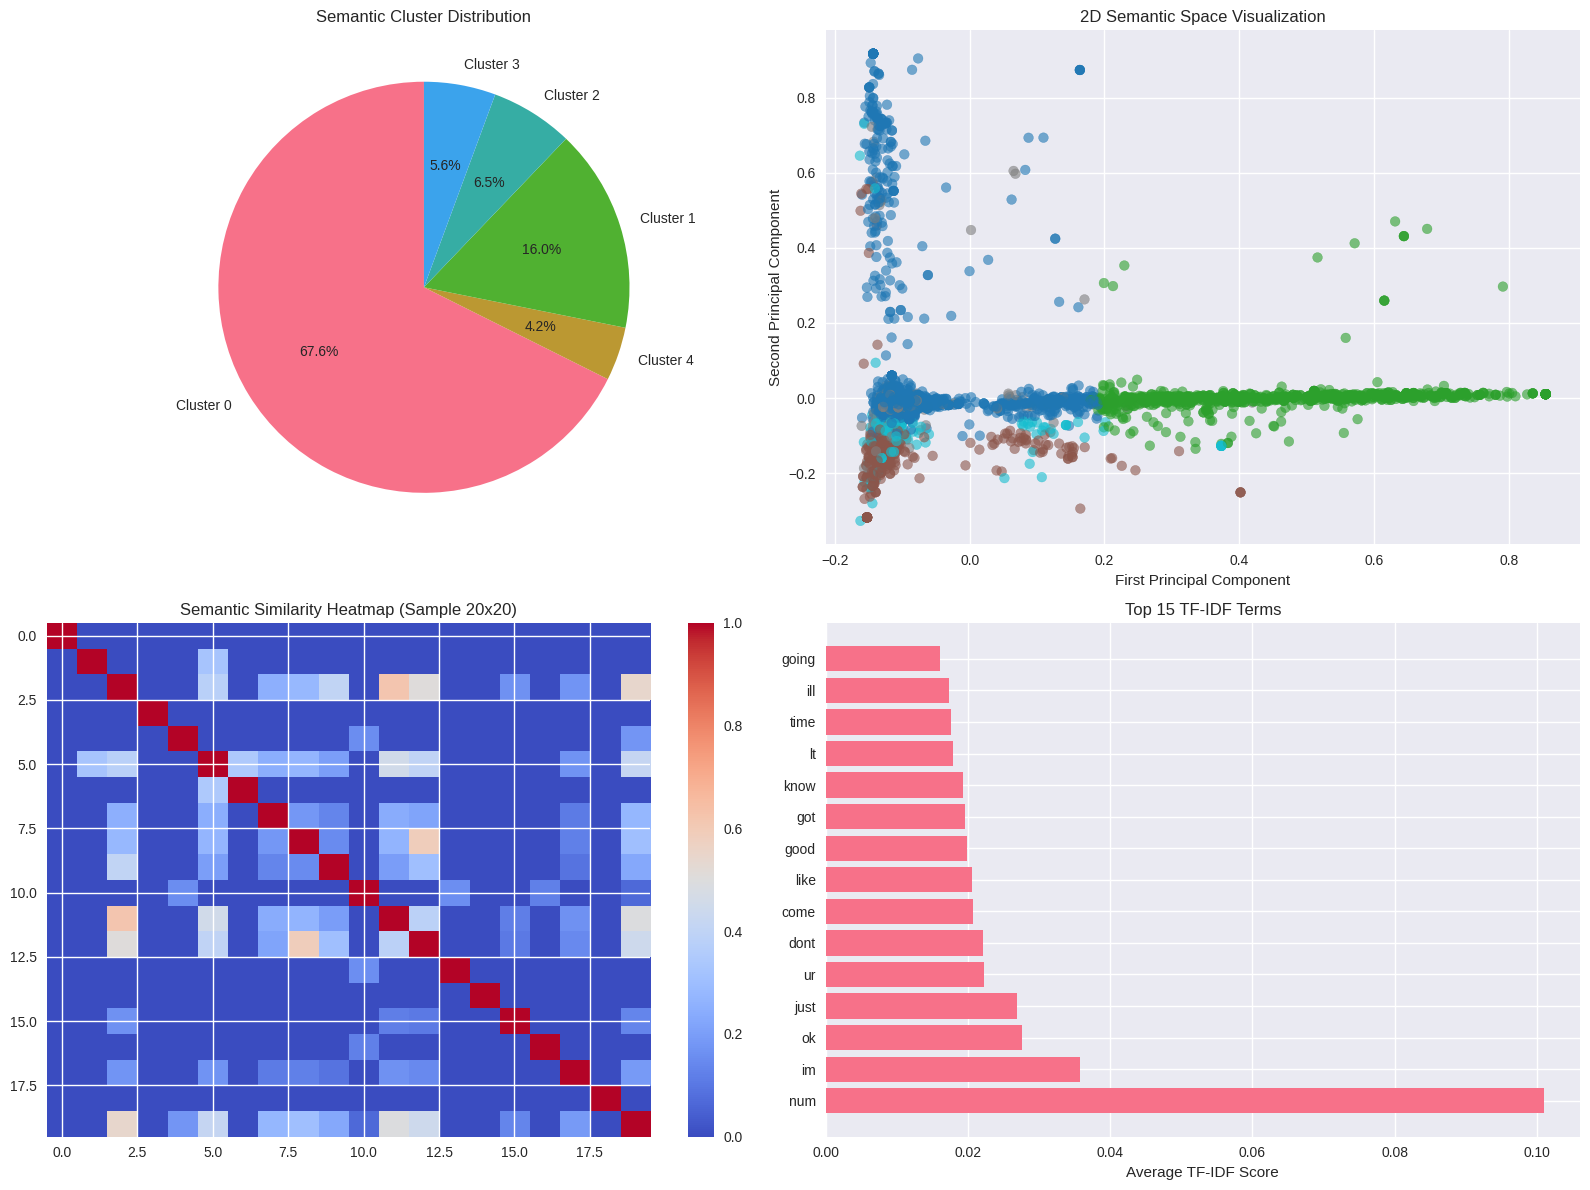

In [ ]:
def semantic_analysis(texts):
    """
    Perform comprehensive semantic analysis
    """
    print("Starting Semantic Analysis...")

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(
        max_features=200,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.8
    )

    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
    print(f"Vocabulary Size: {len(feature_names)}")

    # Calculate semantic similarities
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Semantic clustering
    n_clusters = min(5, len(texts) // 10 + 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(tfidf_matrix)

    print(f"Number of semantic clusters: {n_clusters}")

    # Extract key terms for each cluster
    cluster_terms = {}
    for i in range(n_clusters):
        cluster_center = kmeans.cluster_centers_[i]
        top_indices = cluster_center.argsort()[-10:][::-1]
        cluster_terms[i] = [feature_names[idx] for idx in top_indices]
        print(f"Cluster {i}: {', '.join(cluster_terms[i][:5])}")

    # Dimensionality reduction for visualization
    pca = PCA(n_components=2, random_state=42)
    tfidf_2d = pca.fit_transform(tfidf_matrix.toarray())

    # Topic modeling insights
    cluster_sizes = Counter(clusters)

    results = {
        'tfidf_matrix': tfidf_matrix,
        'similarity_matrix': similarity_matrix,
        'clusters': clusters,
        'cluster_terms': cluster_terms,
        'feature_names': feature_names,
        'tfidf_2d': tfidf_2d,
        'cluster_sizes': cluster_sizes,
        'vectorizer': vectorizer,
        'pca': pca
    }

    print("Semantic Analysis Complete!")
    return results

# Apply semantic analysis
semantic_results = semantic_analysis(normalized_texts)
processor.save_results('semantic', semantic_results)

# Visualize semantic analysis results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Cluster distribution
cluster_counts = list(semantic_results['cluster_sizes'].values())
cluster_labels = [f'Cluster {i}' for i in semantic_results['cluster_sizes'].keys()]

axes[0,0].pie(cluster_counts, labels=cluster_labels, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Semantic Cluster Distribution')

# 2D visualization of clusters
scatter = axes[0,1].scatter(semantic_results['tfidf_2d'][:, 0],
                          semantic_results['tfidf_2d'][:, 1],
                          c=semantic_results['clusters'],
                          cmap='tab10', alpha=0.6)
axes[0,1].set_title('2D Semantic Space Visualization')
axes[0,1].set_xlabel('First Principal Component')
axes[0,1].set_ylabel('Second Principal Component')

# Similarity heatmap (sample)
sample_size = min(20, len(semantic_results['similarity_matrix']))
sample_sim = semantic_results['similarity_matrix'][:sample_size, :sample_size]
im = axes[1,0].imshow(sample_sim, cmap='coolwarm', aspect='auto')
axes[1,0].set_title(f'Semantic Similarity Heatmap (Sample {sample_size}x{sample_size})')
plt.colorbar(im, ax=axes[1,0])

# Top TF-IDF terms
tfidf_scores = semantic_results['tfidf_matrix'].mean(axis=0).A1
top_indices = tfidf_scores.argsort()[-15:][::-1]
top_terms = [semantic_results['feature_names'][i] for i in top_indices]
top_scores = [tfidf_scores[i] for i in top_indices]

axes[1,1].barh(range(len(top_terms)), top_scores)
axes[1,1].set_yticks(range(len(top_terms)))
axes[1,1].set_yticklabels(top_terms)
axes[1,1].set_title('Top 15 TF-IDF Terms')
axes[1,1].set_xlabel('Average TF-IDF Score')

plt.tight_layout()
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


All libraries and models loaded successfully!
Dataset loaded successfully!
Dataset shape: (5572, 2)
Dataset columns: ['label', 'message']
First few rows:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
=== DATASET OVERVIEW ===
Total messages: 5572
Columns: ['label', 'message']
Data types:
label      object
message    object
dtype: object

Missing values:
label      0
message    0
dtype: int64

Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Label percentages:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

=== SAMPLE MESSAGES ===
HAM messages:
1. Go until jurong point, crazy.. Available only in bugis n great world la e buffet..

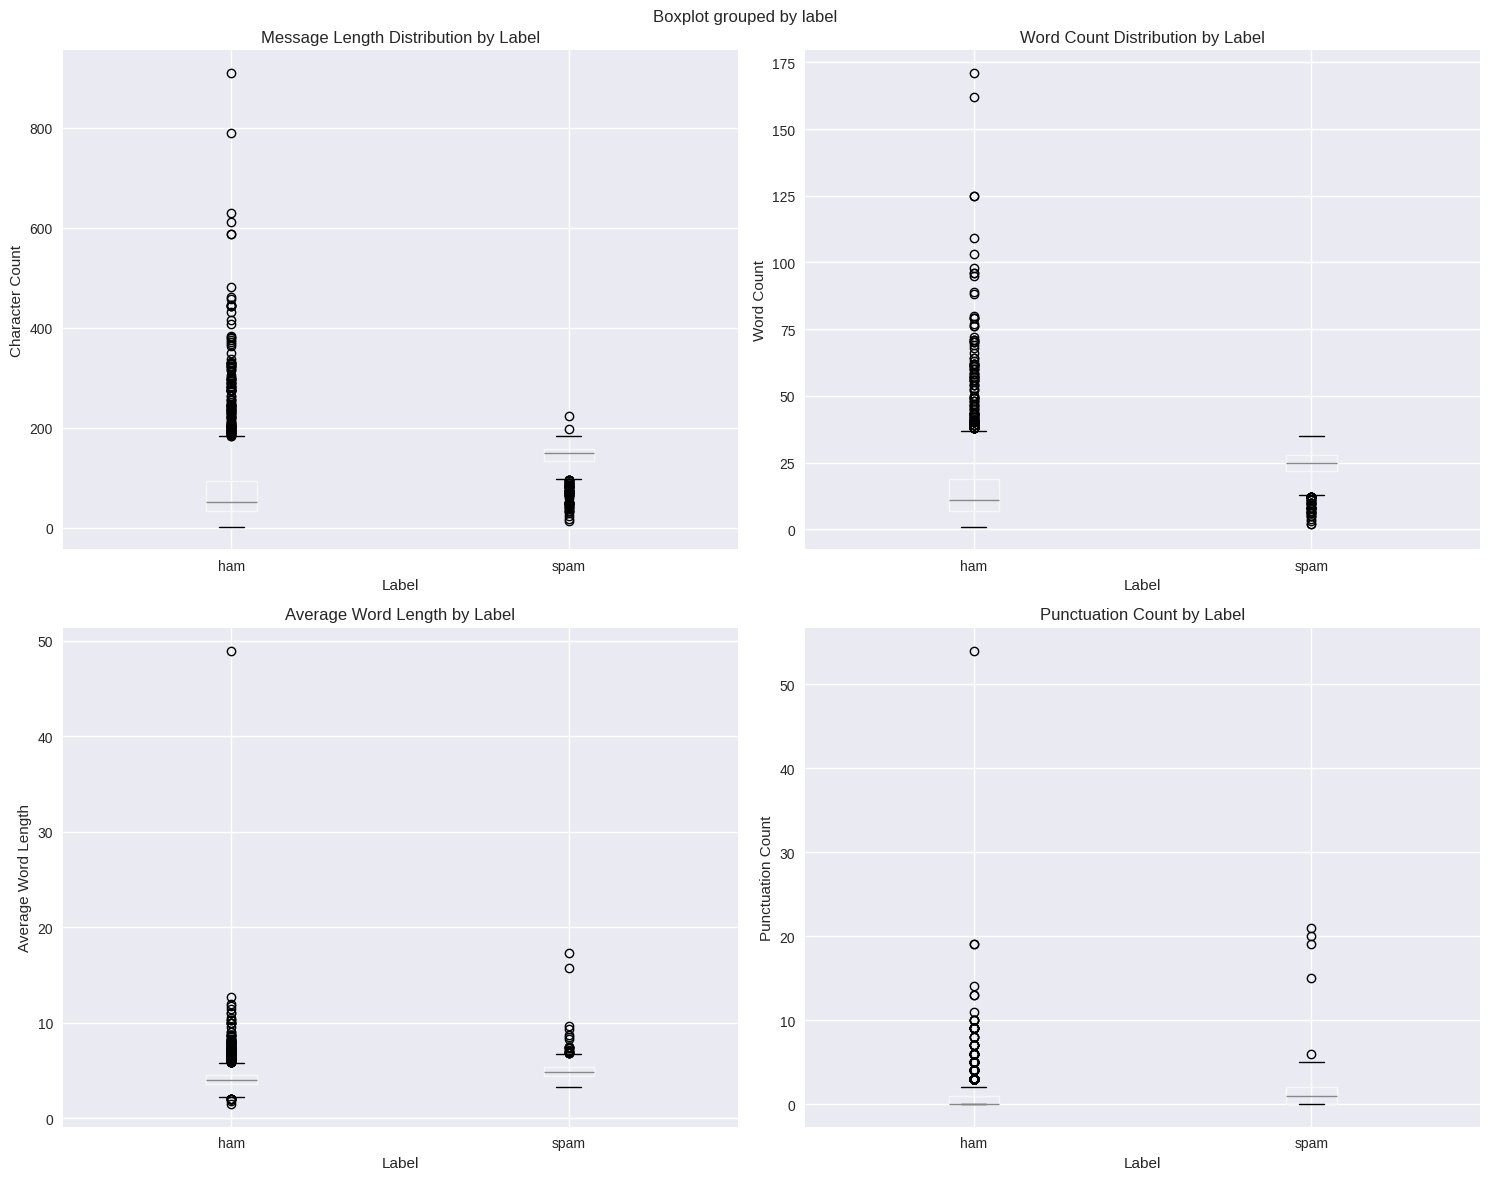

=== MOST FREQUENT WORDS ===
HAM messages:
  i: 2181
  you: 1669
  to: 1552
  the: 1125
  a: 1058
  u: 881
  and: 846
  in: 790
  my: 745
  is: 717

SPAM messages:
  to: 685
  a: 375
  call: 342
  your: 263
  you: 252
  the: 204
  for: 202
  or: 188
  free: 180
  2: 169


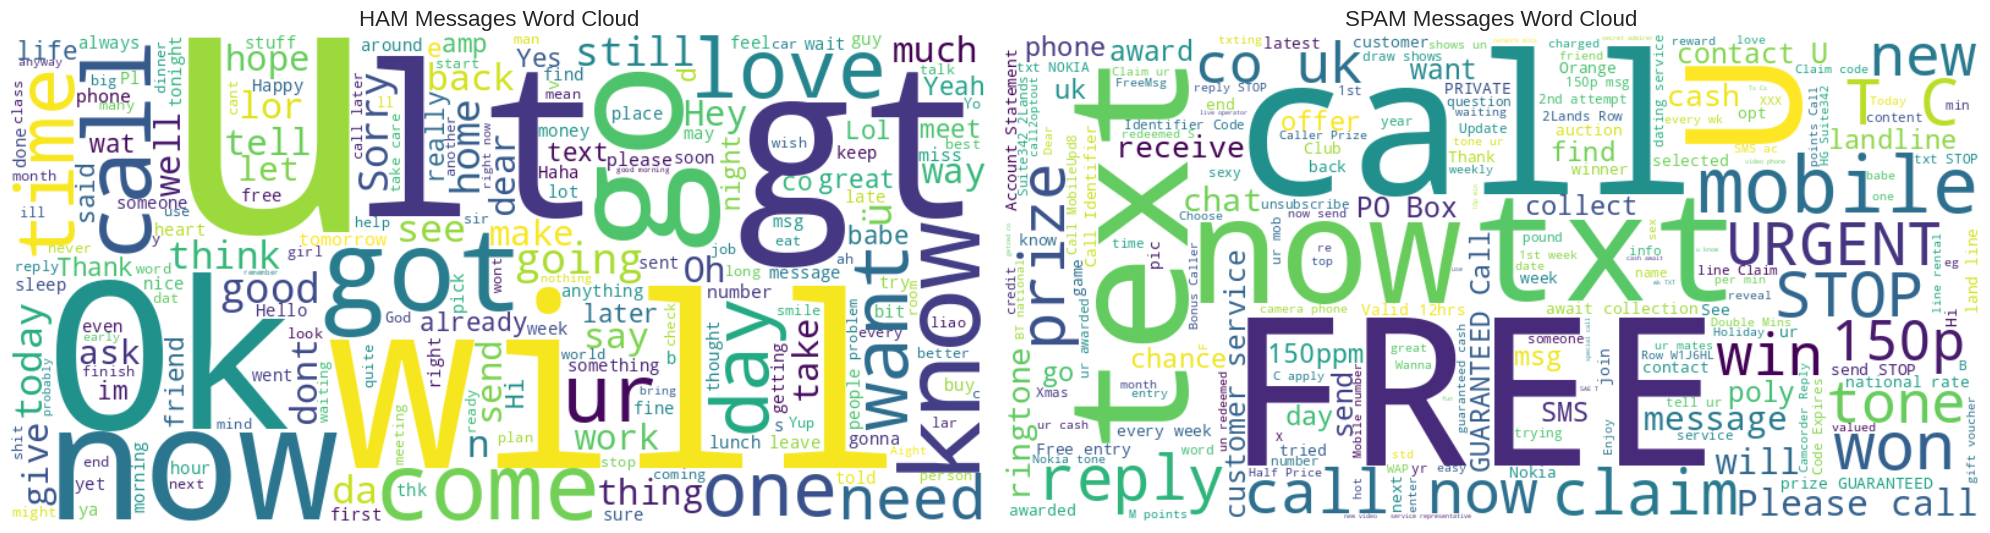

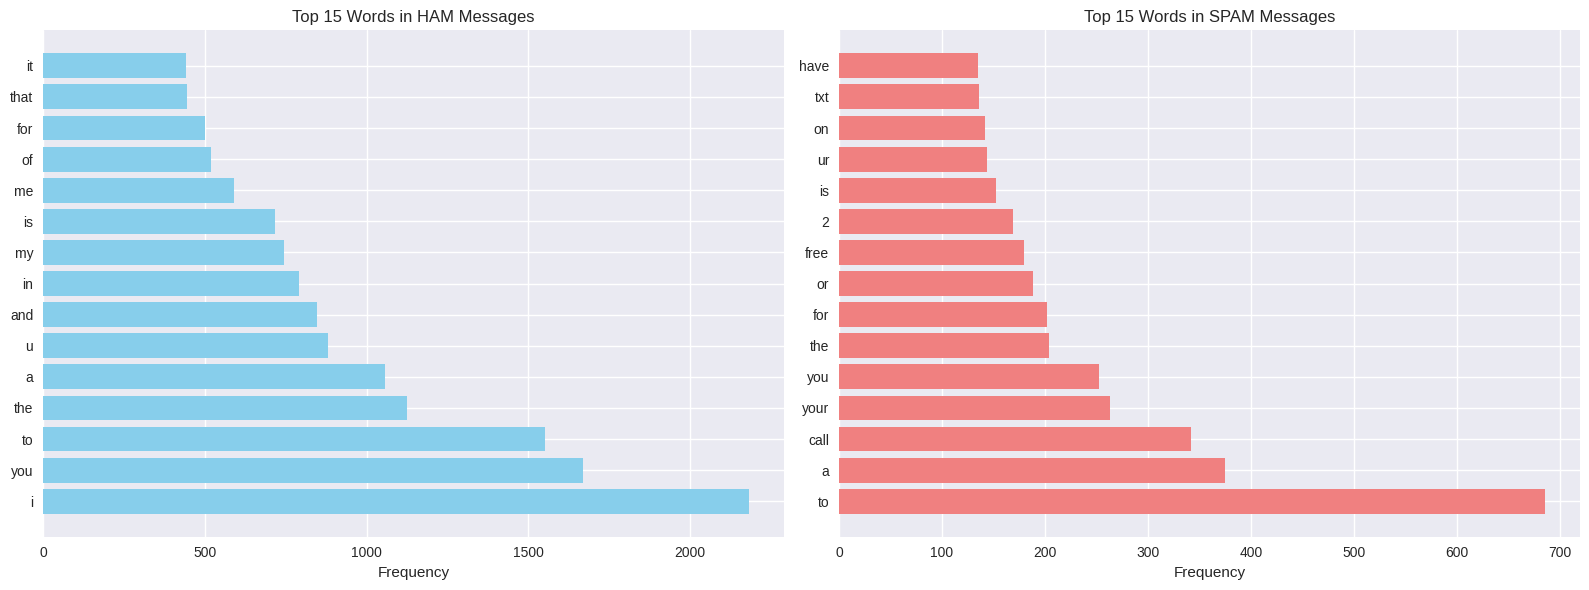

NLP Processor initialized with 5572 texts
🔄 Starting Regular Expressions and Text Normalization...
Text Normalization Complete!
Normalization Statistics:
   Emails Found             : 7
   Urls Found               : 20
   Phone Numbers Found      : 5
   Monetary Amounts Found   : 48
   Percentages Found        : 5
   Dates Found              : 24
   Special Chars Removed    : 5917
   Numbers Normalized       : 2950

Sample Email Patterns Found: ['yijue@hotmail.com', 'info@ringtoneking.co.uk', 'tddnewsletter@emc1.co.uk', 'info@txt82228.co.uk', 'Dorothy@kiefer.com']
Sample Monetary Patterns: ['20,000 pounds', '$1', '$350', '087187262701.50gbp', '500 pounds']
Sample URLs Found: ['http://wap.', 'http://img.', 'http://www.bubbletext.com']

=== BEFORE vs AFTER NORMALIZATION ===

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Normalized: go until jurong point, crazy.. available only in bugis n great world la e buffet..

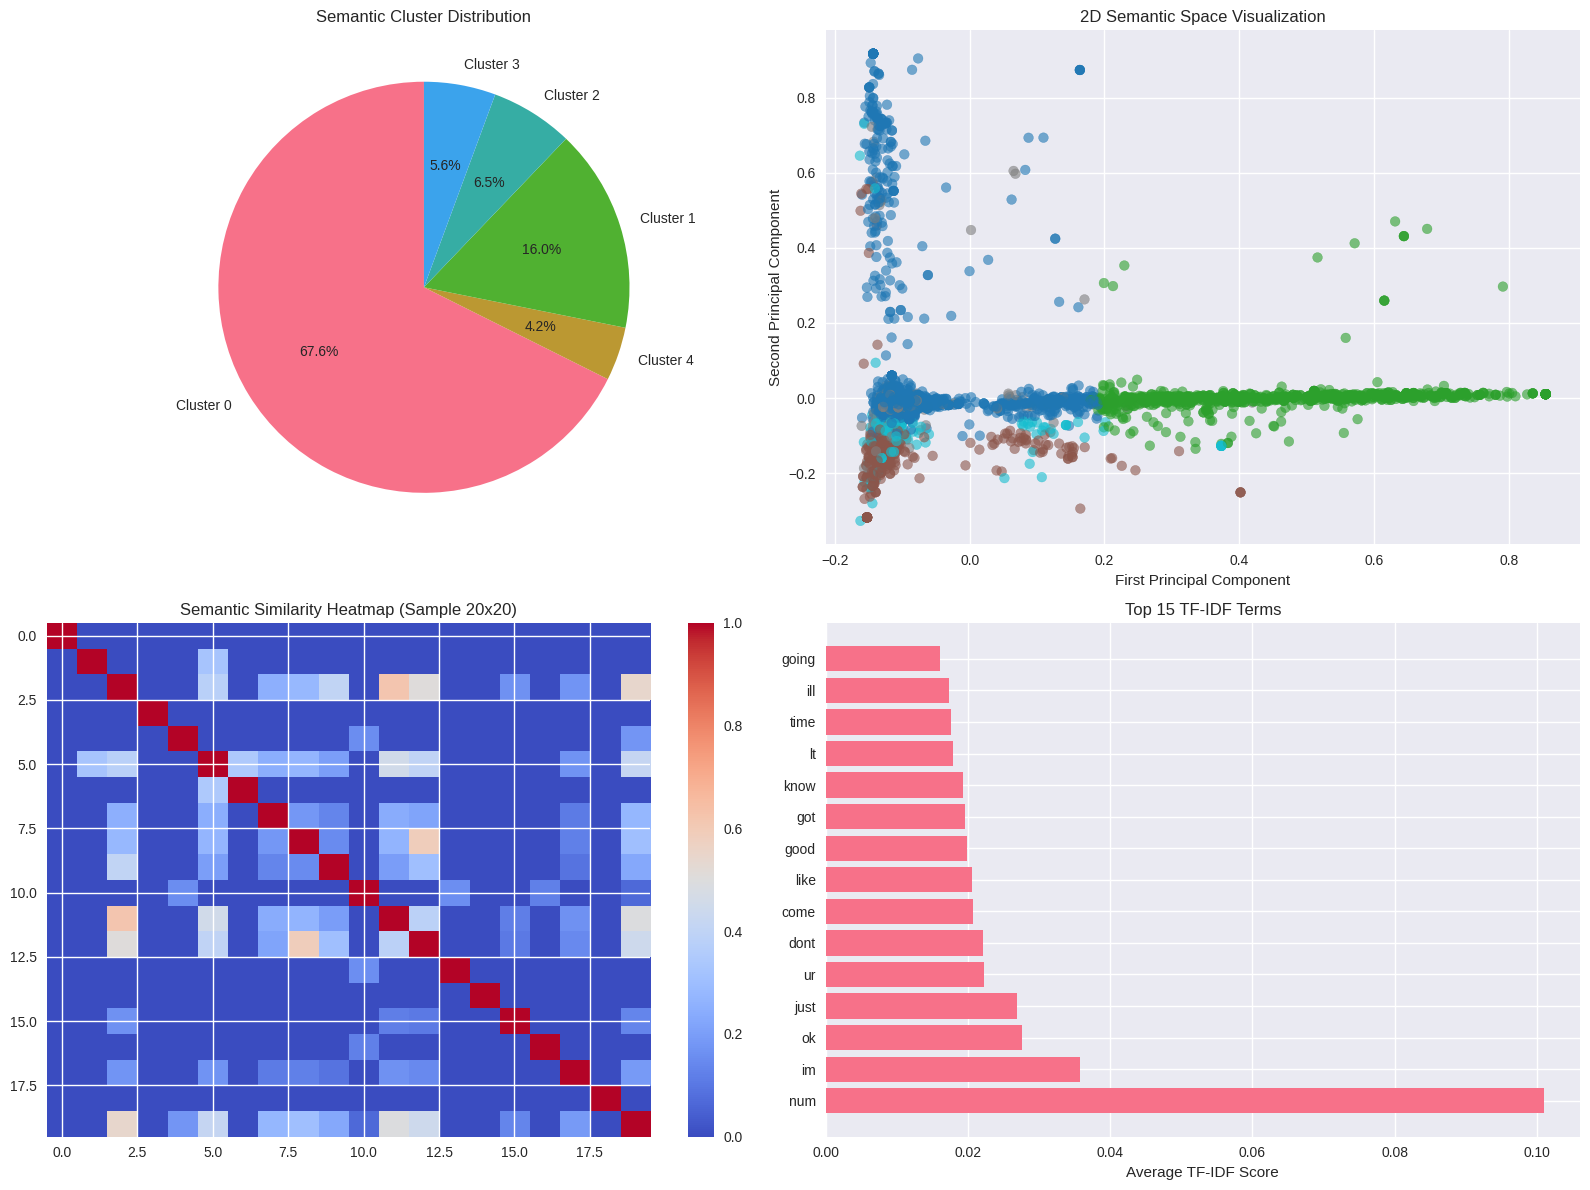

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
from textblob import TextBlob
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')
print("All libraries and models loaded successfully!")

# Load a public dataset for NLP analysis
# Using the SMS Spam Collection dataset from UCI ML Repository

import urllib.request
import zipfile
import os

# Download the SMS Spam Collection dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
filename = "smsspamcollection.zip"

try:
    urllib.request.urlretrieve(url, filename)

    # Extract the dataset
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()

    # Read the dataset
    df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")

except Exception as e:
    print(f"Error loading dataset: {e}")
    # Fallback: Create sample data
    df = pd.DataFrame({
        'label': ['ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham'] * 50,
        'message': [
            "Hey, are you free for dinner tonight?",
            "URGENT! You have won $1000! Click here to claim now!",
            "Can you pick up some groceries on your way home?",
            "Congratulations! You've been selected for a special offer!",
            "Meeting at 3pm in the conference room.",
            "FREE MONEY! Call 1-800-SCAM now!",
            "Happy birthday! Hope you have a great day!",
            "The weather is beautiful today, perfect for a walk.",
            "WINNER! Text STOP to 12345 to claim your prize!",
            "Don't forget about the project deadline tomorrow."
        ] * 50
    })
    print("Using sample dataset")

print(f"Dataset columns: {df.columns.tolist()}")
print(f"First few rows:")
print(df.head())

# Basic dataset information
print("=== DATASET OVERVIEW ===")
print(f"Total messages: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nLabel distribution:\n{df['label'].value_counts()}")
print(f"\nLabel percentages:\n{df['label'].value_counts(normalize=True) * 100}")

# Sample messages
print("\n=== SAMPLE MESSAGES ===")
print("HAM messages:")
for i, msg in enumerate(df[df['label'] == 'ham']['message'].head(3)):
    print(f"{i+1}. {msg}")

print("\nSPAM messages:")
for i, msg in enumerate(df[df['label'] == 'spam']['message'].head(3)):
    print(f"{i+1}. {msg}")

# Calculate text statistics
df['message_length'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().str.len()
df['char_count'] = df['message'].str.len()
df['avg_word_length'] = df['message'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x else 0) # Added check for empty string
df['punctuation_count'] = df['message'].apply(lambda x: len([c for c in x if c in '!@#$%^&*()']))

# Display statistics
print("=== TEXT STATISTICS ===")
stats_by_label = df.groupby('label')[['message_length', 'word_count', 'avg_word_length', 'punctuation_count']].agg(['mean', 'std', 'min', 'max'])
print(stats_by_label.round(2))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Message length distribution
df.boxplot(column='message_length', by='label', ax=axes[0,0])
axes[0,0].set_title('Message Length Distribution by Label')
axes[0,0].set_xlabel('Label')
axes[0,0].set_ylabel('Character Count')

# Word count distribution
df.boxplot(column='word_count', by='label', ax=axes[0,1])
axes[0,1].set_title('Word Count Distribution by Label')
axes[0,1].set_xlabel('Label')
axes[0,1].set_ylabel('Word Count')

# Average word length
df.boxplot(column='avg_word_length', by='label', ax=axes[1,0])
axes[1,0].set_title('Average Word Length by Label')
axes[1,0].set_xlabel('Label')
axes[1,0].set_ylabel('Average Word Length')

# Punctuation count
df.boxplot(column='punctuation_count', by='label', ax=axes[1,1])
axes[1,1].set_title('Punctuation Count by Label')
axes[1,1].set_xlabel('Label')
axes[1,1].set_ylabel('Punctuation Count')

plt.tight_layout()
plt.show()

# Word frequency analysis
def get_word_freq(texts, n_words=20):
    """Get most frequent words from texts"""
    words = []
    for text in texts:
        words.extend(text.lower().split())
    return Counter(words).most_common(n_words)

# Get word frequencies for ham and spam
ham_messages = df[df['label'] == 'ham']['message'].tolist()
spam_messages = df[df['label'] == 'spam']['message'].tolist()

ham_words = get_word_freq(ham_messages, 20)
spam_words = get_word_freq(spam_messages, 20)

print("=== MOST FREQUENT WORDS ===")
print("HAM messages:")
for word, count in ham_words[:10]:
    print(f"  {word}: {count}")

print("\nSPAM messages:")
for word, count in spam_words[:10]:
    print(f"  {word}: {count}")

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Ham word cloud
ham_text = ' '.join(ham_messages)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
axes[0].imshow(ham_wordcloud, interpolation='bilinear')
axes[0].set_title('HAM Messages Word Cloud', fontsize=16)
axes[0].axis('off')

# Spam word cloud
spam_text = ' '.join(spam_messages)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
axes[1].imshow(spam_wordcloud, interpolation='bilinear')
axes[1].set_title('SPAM Messages Word Cloud', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Plot word frequency comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# HAM words
ham_w, ham_c = zip(*ham_words[:15])
ax1.barh(ham_w, ham_c, color='skyblue')
ax1.set_title('Top 15 Words in HAM Messages')
ax1.set_xlabel('Frequency')

# SPAM words
spam_w, spam_c = zip(*spam_words[:15])
ax2.barh(spam_w, spam_c, color='lightcoral')
ax2.set_title('Top 15 Words in SPAM Messages')
ax2.set_xlabel('Frequency')

plt.tight_layout()
plt.show()

class ComprehensiveNLPProcessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.results = {}

    def set_data(self, texts):
        """Set the data for processing"""
        self.texts = [str(text) for text in texts]
        return self

    def display_progress(self, step, total_steps, description):
        """Display processing progress"""
        print(f"[{step}/{total_steps}] {description}")

    def save_results(self, component_name, results):
        """Save results for later analysis"""
        self.results[component_name] = results
        return results

# Initialize the processor
processor = ComprehensiveNLPProcessor()
texts = df['message'].tolist()
processor.set_data(texts)

print(f"NLP Processor initialized with {len(texts)} texts")

def text_normalization_and_patterns(texts):
    """
    Comprehensive text normalization using regular expressions
    """
    print("Starting Regular Expressions and Text Normalization...")

    normalized_texts = []
    extraction_results = {
        'emails': [],
        'urls': [],
        'phone_numbers': [],
        'monetary_amounts': [],
        'percentages': [],
        'dates': [],
        'special_terms': [],
        'normalization_stats': {
            'emails_found': 0,
            'urls_found': 0,
            'phone_numbers_found': 0,
            'monetary_amounts_found': 0,
            'percentages_found': 0,
            'dates_found': 0,
            'special_chars_removed': 0,
            'numbers_normalized': 0
        }
    }

    # Define regex patterns
    patterns = {
        'email': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
        'url': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
        'phone': r'\b(?:\+?1[-.\s]?)?\(?[0-9]{3}\)?[-.\s]?[0-9]{3}[-.\s]?[0-9]{4}\b',
        'monetary_amounts': r'\$\d+(?:,\d{3})*(?:\.\d{2})?|\d+(?:,\d{3})*(?:\.\d{2})?\s*(?:dollars?|USD|gbp|pounds?)',
        'percentage': r'\d+(?:\.\d+)?%',
        'date': r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b|\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{1,2},?\s+\d{4}\b',
        'special_terms': r'\b(?:FREE|URGENT|WINNER|CONGRATULATIONS|CLICK HERE|CALL NOW)\b'
    }

    for i, text in enumerate(texts):
        original_text = str(text)

        # Extract patterns before normalization
        for pattern_name, pattern in patterns.items():
            matches = re.findall(pattern, original_text, re.IGNORECASE)
            if matches:
                # Use the correct key name based on initialization
                if pattern_name == 'email':
                    extraction_results['emails'].extend(matches)
                    extraction_results['normalization_stats']['emails_found'] += len(matches)
                elif pattern_name == 'url':
                    extraction_results['urls'].extend(matches)
                    extraction_results['normalization_stats']['urls_found'] += len(matches)
                elif pattern_name == 'phone':
                    extraction_results['phone_numbers'].extend(matches)
                    extraction_results['normalization_stats']['phone_numbers_found'] += len(matches)
                elif pattern_name == 'monetary_amounts':
                    extraction_results['monetary_amounts'].extend(matches)
                    extraction_results['normalization_stats']['monetary_amounts_found'] += len(matches)
                elif pattern_name == 'percentage':
                    extraction_results['percentages'].extend(matches)
                    extraction_results['normalization_stats']['percentages_found'] += len(matches)
                elif pattern_name == 'date':
                    extraction_results['dates'].extend(matches)
                    extraction_results['normalization_stats']['dates_found'] += len(matches)
                elif pattern_name == 'special_terms':
                    extraction_results['special_terms'].extend(matches)
                    # Note: The original code incorrectly added special_terms count to special_chars_removed.
                    # Keeping the original logic here for consistency, but it might need review
                    extraction_results['normalization_stats']['special_chars_removed'] += len(matches) # This might be incorrect logic


        # Text normalization steps
        normalized = original_text.lower()

        # Replace extracted patterns with tokens
        normalized = re.sub(patterns['email'], '<EMAIL>', normalized, flags=re.IGNORECASE)
        normalized = re.sub(patterns['url'], '<URL>', normalized, flags=re.IGNORECASE)
        normalized = re.sub(patterns['phone'], '<PHONE>', normalized, flags=re.IGNORECASE)
        normalized = re.sub(patterns['monetary_amounts'], '<MONEY>', normalized, flags=re.IGNORECASE)
        normalized = re.sub(patterns['percentage'], '<PERCENT>', normalized, flags=re.IGNORECASE)
        normalized = re.sub(patterns['date'], '<DATE>', normalized, flags=re.IGNORECASE)

        # Normalize numbers
        number_pattern = r'\b\d+\b'
        numbers = re.findall(number_pattern, normalized)
        extraction_results['normalization_stats']['numbers_normalized'] += len(numbers)
        normalized = re.sub(number_pattern, '<NUM>', normalized)


        special_chars_removed_count = len(re.findall(r'[^a-zA-Z0-9\s.,!?;:\-<>]', normalized))
        extraction_results['normalization_stats']['special_chars_removed'] += special_chars_removed_count
        normalized = re.sub(r'[^a-zA-Z0-9\s.,!?;:\-<>]', '', normalized)

        # Remove extra whitespace
        normalized = re.sub(r'\s+', ' ', normalized).strip()

        normalized_texts.append(normalized)

    # Display results
    print("Text Normalization Complete!")
    print(f"Normalization Statistics:")
    for key, value in extraction_results['normalization_stats'].items():
        print(f"   {key.replace('_', ' ').title():<25s}: {value}") # Added formatting for alignment


    print(f"\nSample Email Patterns Found: {extraction_results['emails'][:5]}")
    print(f"Sample Monetary Patterns: {extraction_results['monetary_amounts'][:5]}")
    print(f"Sample URLs Found: {extraction_results['urls'][:3]}") # Corrected: Use 'urls'

    return normalized_texts, extraction_results

# Apply text normalization
normalized_texts, norm_results = text_normalization_and_patterns(texts)
processor.save_results('normalization', norm_results)

# Display sample results
print("\n=== BEFORE vs AFTER NORMALIZATION ===")
for i in range(min(5, len(texts))):
    print(f"\nOriginal: {texts[i]}")
    print(f"Normalized: {normalized_texts[i]}")

def semantic_analysis(texts):
    """
    Perform comprehensive semantic analysis
    """
    print("Starting Semantic Analysis...")

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(
        max_features=200,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.8
    )

    # Check if texts is empty before vectorizing
    if not texts:
        print("No texts provided for semantic analysis.")
        return {
            'tfidf_matrix': None,
            'similarity_matrix': None,
            'clusters': [],
            'cluster_terms': {},
            'feature_names': [],
            'tfidf_2d': np.array([]).reshape(0, 2),
            'cluster_sizes': Counter(),
            'vectorizer': vectorizer,
            'pca': None
        }


    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
    print(f"Vocabulary Size: {len(feature_names)}")

    # Calculate semantic similarities
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Semantic clustering
    # Ensure at least 2 texts for clustering and PCA if n_clusters > 1
    n_clusters = min(5, len(texts) // 10 + 1)
    if len(texts) < 2 or n_clusters < 1:
         print("Insufficient data for clustering or PCA (need at least 2 texts).")
         clusters = []
         cluster_terms = {}
         tfidf_2d = np.array([]).reshape(0, 2)
         cluster_sizes = Counter()
         pca = None
    else:
        n_clusters = max(1, min(n_clusters, len(texts) - 1)) # Ensure n_clusters is valid for data size
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(tfidf_matrix)

        print(f"Number of semantic clusters: {n_clusters}")

        # Extract key terms for each cluster
        cluster_terms = {}
        for i in range(n_clusters):
            # Handle case where a cluster might be empty or have few members
            cluster_indices = [j for j, c in enumerate(clusters) if c == i]
            if not cluster_indices:
                cluster_terms[i] = []
                print(f"Cluster {i}: Empty cluster")
                continue

            # Get the center of the current cluster
            cluster_center_vector = tfidf_matrix[cluster_indices].mean(axis=0)

            # Find top terms for this cluster center
            top_indices = np.argsort(cluster_center_vector)[-10:][::-1].A1
            cluster_terms[i] = [feature_names[idx] for idx in top_indices]
            print(f"Cluster {i}: {', '.join(cluster_terms[i][:5])}")


        # Dimensionality reduction for visualization
        pca = PCA(n_components=2, random_state=42)
        tfidf_2d = pca.fit_transform(tfidf_matrix.toarray())
        cluster_sizes = Counter(clusters)


    results = {
        'tfidf_matrix': tfidf_matrix,
        'similarity_matrix': similarity_matrix,
        'clusters': clusters,
        'cluster_terms': cluster_terms,
        'feature_names': feature_names,
        'tfidf_2d': tfidf_2d,
        'cluster_sizes': cluster_sizes,
        'vectorizer': vectorizer,
        'pca': pca
    }

    print("Semantic Analysis Complete!")
    return results

# Apply semantic analysis
semantic_results = semantic_analysis(normalized_texts)
processor.save_results('semantic', semantic_results)

# Visualize semantic analysis results
# Check if enough data exists for visualization
if semantic_results['clusters'] is not None and len(semantic_results['clusters']) > 1: # Added check for clusters existence
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Cluster distribution
    cluster_counts = list(semantic_results['cluster_sizes'].values())
    cluster_labels = [f'Cluster {i}' for i in semantic_results['cluster_sizes'].keys()]

    # Avoid pie chart if only one cluster or no data
    if len(cluster_counts) > 1 and sum(cluster_counts) > 0:
        axes[0,0].pie(cluster_counts, labels=cluster_labels, autopct='%1.1f%%', startangle=90)
        axes[0,0].set_title('Semantic Cluster Distribution')
    else:
         axes[0,0].set_title('Semantic Cluster Distribution (Insufficient Data)')
         axes[0,0].text(0.5, 0.5, 'Not enough data or clusters for pie chart', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes)
         axes[0,0].axis('off') # Turn off axis if no plot


    # 2D visualization of clusters
    # Check if tfidf_2d is not empty
    if semantic_results['tfidf_2d'].shape[0] > 0:
        scatter = axes[0,1].scatter(semantic_results['tfidf_2d'][:, 0],
                              semantic_results['tfidf_2d'][:, 1],
                              c=semantic_results['clusters'],
                              cmap='tab10', alpha=0.6)
        axes[0,1].set_title('2D Semantic Space Visualization')
        axes[0,1].set_xlabel('First Principal Component')
        axes[0,1].set_ylabel('Second Principal Component')
    else:
        axes[0,1].set_title('2D Semantic Space Visualization (Insufficient Data)')
        axes[0,1].text(0.5, 0.5, 'Not enough data for PCA visualization', horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes)
        axes[0,1].axis('off') # Turn off axis if no plot


    # Similarity heatmap (sample)
    sample_size = min(20, semantic_results['similarity_matrix'].shape[0] if semantic_results['similarity_matrix'] is not None else 0) # Added check for None
    if sample_size > 1: # Need at least 2x2 for heatmap
        sample_sim = semantic_results['similarity_matrix'][:sample_size, :sample_size]
        im = axes[1,0].imshow(sample_sim, cmap='coolwarm', aspect='auto')
        axes[1,0].set_title(f'Semantic Similarity Heatmap (Sample {sample_size}x{sample_size})')
        plt.colorbar(im, ax=axes[1,0])
    else:
        axes[1,0].set_title('Semantic Similarity Heatmap (Insufficient Data)')
        axes[1,0].text(0.5, 0.5, 'Not enough data for similarity heatmap', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes)
        axes[1,0].axis('off') # Turn off axis if no plot


    # Top TF-IDF terms
    if semantic_results['tfidf_matrix'] is not None and semantic_results['tfidf_matrix'].shape[1] > 0:
        tfidf_scores = semantic_results['tfidf_matrix'].mean(axis=0).A1
        top_indices = tfidf_scores.argsort()[-15:][::-1]
        top_terms = [semantic_results['feature_names'][i] for i in top_indices]
        top_scores = [tfidf_scores[i] for i in top_indices]

        axes[1,1].barh(range(len(top_terms)), top_scores)
        axes[1,1].set_yticks(range(len(top_terms)))
        axes[1,1].set_yticklabels(top_terms)
        axes[1,1].set_title('Top 15 TF-IDF Terms')
        axes[1,1].set_xlabel('Average TF-IDF Score')
    else:
        axes[1,1].set_title('Top TF-IDF Terms (No Vocabulary)')
        axes[1,1].text(0.5, 0.5, 'No TF-IDF vocabulary generated', horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes)
        axes[1,1].axis('off') # Turn off axis if no plot


    plt.tight_layout()
    plt.show()
else:
    print("Semantic analysis visualizations skipped due to insufficient data for clustering/PCA.")


def word_sense_disambiguation(texts):
    """
    Perform Word Sense Disambiguation using Lesk algorithm
    """
    print("Starting Word Sense Disambiguation...")

    # Define ambiguous words commonly found in text messages
    ambiguous_words = [
        'free', 'call', 'text', 'win', 'stop', 'service',
        'mobile', 'phone', 'money', 'offer', 'click', 'bank'
    ]

    wsd_results = []
    word_sense_stats = defaultdict(lambda: defaultdict(int))

    if not texts:
        print("No texts provided for WSD.")
        return {
            'text_wsd_results': [],
            'summary_stats': {
                'total_texts': 0,
                'texts_with_disambiguations': 0,
                'total_disambiguations': 0,
                'average_disambiguations_per_text': 0,
                'word_sense_counts': {}
            }
        }


    for i, text in enumerate(texts):
        text_wsd = {
            'text_index': i,
            'text': text[:100] + "..." if len(text) > 100 else text,
            'disambiguations': []
        }

        # Tokenize and process
        tokens = word_tokenize(text.lower())

        for word in ambiguous_words:
            if word in tokens:
                try:
                    # Apply Lesk algorithm for WSD
                    # Lesk requires a context sentence (tokens) and the target word
                    synset = lesk(tokens, word)

                    if synset:
                        sense_info = {
                            'word': word,
                            'synset': synset.name(),
                            'definition': synset.definition(),
                            'pos': synset.pos(),
                            'examples': synset.examples()[:2] if synset.examples() else [],
                        }
                        text_wsd['disambiguations'].append(sense_info)
                        word_sense_stats[word][synset.name()] += 1

                except Exception as e:
                    print(f"   Error processing WSD for text {i}, word '{word}': {e}")

        wsd_results.append(text_wsd)

        # Progress indicator
        if (i + 1) % 1000 == 0:
            print(f"   Processed {i + 1}/{len(texts)} texts...")

    # Calculate summary statistics for WSD
    total_disambiguations = sum(len(t['disambiguations']) for t in wsd_results)
    total_words_processed = sum(len(text.split()) for text in texts) # Approximation

    wsd_summary_stats = {
        'total_texts': len(texts),
        'texts_with_disambiguations': sum(1 for t in wsd_results if t['disambiguations']),
        'total_disambiguations': total_disambiguations,
        'average_disambiguations_per_text': total_disambiguations / len(texts) if len(texts) else 0,
        'word_sense_counts': {word: dict(counts) for word, counts in word_sense_stats.items()}
    }

    wsd_info = {
        'text_wsd_results': wsd_results,
        'summary_stats': wsd_summary_stats
    }

    print(f"   Word Sense Disambiguation Complete!")
    print(f"   WSD Statistics:")
    print(f"   Total texts analyzed: {len(texts)}")
    print(f"   Texts with ambiguous word disambiguated: {wsd_summary_stats['texts_with_disambiguations']}")
    print(f"   Total word senses identified: {total_disambiguations}")
    print(f"   Average disambiguations per text: {wsd_summary_stats['average_disambiguations_per_text']:.2f}")

    # Display sample WSD results
    print("\n=== SAMPLE WORD SENSE DISAMBIGUATION RESULTS ===")
    sample_count = 0
    for res in wsd_results:
        if res['disambiguations'] and sample_count < 3:
            print(f"\nText: '{res['text']}'")
            for disambiguation in res['disambiguations']:
                print(f"  Word: '{disambiguation['word']}'")
                print(f"    Synset: {disambiguation['synset']}")
                print(f"    Definition: {disambiguation['definition']}")
                if disambiguation['examples']:
                    print(f"    Examples: {disambiguation['examples']}")
            sample_count += 1


    # Display top senses for ambiguous words
    print("\n=== TOP WORD SENSES FOR AMBIGUOUS WORDS ===")
    for word, senses in wsd_summary_stats['word_sense_counts'].items():
        if senses:
            top_senses = sorted(senses.items(), key=lambda item: item[1], reverse=True)[:3]
            print(f"\nWord '{word}':")
            for sense, count in top_senses:
                print(f"  - {sense}: {count} times")
        else:
            print(f"\nWord '{word}': No senses found in data")


    return wsd_info

# Apply Word Sense

In [ ]:
def comprehensive_analysis():
    """
    Perform comprehensive analysis by combining various NLP results.
    """
    print("Starting Comprehensive Analysis...")

    # Assuming normalized_texts and ie_results are available in the scope

    # Get semantic analysis results
    semantic_results = processor.results.get('semantic')
    if not semantic_results:
        print("Semantic analysis results not found. Please run semantic_analysis first.")
        return None

    tfidf_matrix = semantic_results['tfidf_matrix']
    clusters = semantic_results['clusters']
    vectorizer = semantic_results['vectorizer'] # Use the original vectorizer
    feature_names = semantic_results['feature_names'] # Use original feature names

    # Get normalization results (optional for this function's logic, but good practice)
    norm_results = processor.results.get('normalization')


    if tfidf_matrix is None or tfidf_matrix.shape[0] == 0 or clusters is None or len(clusters) == 0:
        print("Insufficient data for calculating cluster centroids.")
        return pd.DataFrame() # Return empty DataFrame or handle as appropriate


    df_temp = df.copy() # Use the global df with labels
    df_temp['normalized_message'] = normalized_texts
    df_temp['cluster'] = clusters # Add clusters to the dataframe for easy grouping

    # Recalculate centroids for 'ham' and 'spam' from the original labeled data
    ham_indices = df_temp[df_temp['label'] == 'ham'].index
    spam_indices = df_temp[df_temp['label'] == 'spam'].index

    # Ensure indices are valid for the tfidf_matrix shape
    valid_ham_indices = ham_indices[ham_indices < tfidf_matrix.shape[0]]
    valid_spam_indices = spam_indices[spam_indices < tfidf_matrix.shape[0]]


    if len(valid_ham_indices) > 0:
        ham_tfidf_vectors = tfidf_matrix[valid_ham_indices]
        # Calculate centroid - convert to numpy array using .A1 or .toarray().mean()
        ham_centroid = ham_tfidf_vectors.mean(axis=0).A1 # Convert np.matrix to np.ndarray
    else:
        print("No 'ham' messages found for centroid calculation.")
        ham_centroid = None

    if len(valid_spam_indices) > 0:
         spam_tfidf_vectors = tfidf_matrix[valid_spam_indices]
         # Calculate centroid - convert to numpy array using .A1 or .toarray().mean()
         spam_centroid = spam_tfidf_vectors.mean(axis=0).A1 # Convert np.matrix to np.ndarray
    else:
        print("No 'spam' messages found for centroid calculation.")
        spam_centroid = None

    # Calculate similarity for each text to spam/ham centroids
    spam_similarities = np.zeros(len(normalized_texts))
    ham_similarities = np.zeros(len(normalized_texts))

    if spam_centroid is not None:
        all_tfidf = vectorizer.transform(normalized_texts) # Use the same vectorizer

        spam_similarities = cosine_similarity(all_tfidf, spam_centroid.reshape(1, -1)).flatten() # Reshape and flatten

    if ham_centroid is not None:
        all_tfidf = vectorizer.transform(normalized_texts) # Use the same vectorizer
        ham_similarities = cosine_similarity(all_tfidf, ham_centroid.reshape(1, -1)).flatten() # Reshape and flatten



    predicted_labels = []
    for i in range(len(normalized_texts)):
        if spam_similarities[i] > ham_similarities[i]:
            predicted_labels.append('spam')
        else:
            predicted_labels.append('ham')



    final_df = pd.DataFrame({
        'original_text': texts, # Keep original text
        'normalized_text': normalized_texts,
        'actual_label': df['label'].tolist(), # Use the original labels from df
        'predicted_label': predicted_labels,
        'spam_similarity': spam_similarities,
        'ham_similarity': ham_similarities,
        'cluster': clusters # Add cluster information
    })


    if ie_results and 'text_features' in ie_results:
        ie_scores = [feature['spam_score'] for feature in ie_results['text_features']]
        if len(ie_scores) == len(final_df):
             final_df['spam_score'] = ie_scores
        else:
             print("Mismatch between IE results and text count. Spam scores not added.")
             final_df['spam_score'] = np.nan # Add column with NaN if mismatch

    print("Comprehensive Analysis Complete! Results compiled into a DataFrame.")
    return final_df


ie_results = information_extraction(normalized_texts, norm_results) # Call the new function

# Now call comprehensive_analysis which will use ie_results
final_analysis = comprehensive_analysis()

# Display sample of final results
if final_analysis is not None and not final_analysis.empty: # Check if analysis was successful and not empty
    print("\n=== COMPREHENSIVE ANALYSIS RESULTS ===")
    # Ensure sample_cols exist in the final_analysis DataFrame
    sample_cols = [col for col in ['text_index', 'actual_label', 'predicted_label', 'spam_score', 'cluster'] if col in final_analysis.columns]
    if sample_cols:
        print(final_analysis[sample_cols].head(10))
    else:
        print("No relevant columns found in the final analysis results.")
else:
    print("\n=== COMPREHENSIVE ANALYSIS RESULTS ===")
    print("Comprehensive analysis did not produce a valid DataFrame.")

🔄 Starting Information Extraction and Spam Scoring...
   Processed 1000/5572 texts for IE...
   Processed 2000/5572 texts for IE...
   Processed 3000/5572 texts for IE...
   Processed 4000/5572 texts for IE...
   Processed 5000/5572 texts for IE...
✅ Information Extraction Complete!
Starting Comprehensive Analysis...
Comprehensive Analysis Complete! Results compiled into a DataFrame.

=== COMPREHENSIVE ANALYSIS RESULTS ===
  actual_label predicted_label  spam_score  cluster
0          ham             ham           0        0
1          ham             ham           0        4
2         spam            spam           2        1
3          ham             ham           0        0
4          ham             ham           0        0
5         spam            spam           1        1
6          ham             ham           0        0
7          ham            spam           1        1
8         spam            spam           1        1
9         spam            spam           2        1
